In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
import seaborn as sns

from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

plt.rcParams['figure.figsize'] = [15, 8]

In [2]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix

In [3]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Dropout, BatchNormalization, MaxPooling2D
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential

## Classification with FC Network

In [4]:
df = pd.read_csv('StudentsPerformance.csv')
df.shape

(1000, 8)

In [5]:
df.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


In [6]:
def class_grade(scores):
    if scores >= 90 and scores <= 100:
        return 3
    elif scores >= 75 and scores < 90:
        return 2
    elif scores >= 60 and scores < 75:
        return 1
    elif scores >= 0 and scores < 60:
        return 0

In [7]:
df['mean score'] = (df['math score']+df['reading score']+df['writing score'])/3
df['grade'] = df['mean score'].apply(class_grade)

df['gender'] = df['gender'].apply(lambda x: 0 if x == 'female' else 1)
df['test preparation course'] = df['test preparation course'].apply(lambda x: 0 if x == 'none' else 1)
df['lunch'] = df['lunch'].apply(lambda x: 0 if x == 'free/reduced' else 1)

race_column = {'group A': 0, 'group B': 1, 'group C': 2, 'group D': 3, 'group E': 4}
parental_level_of_education_column = {'high school': 0, 'some high school': 1, 'some college': 2, "associate's degree": 3, 
                                      "bachelor's degree": 4, "master's degree": 5}
df['race/ethnicity'] = df['race/ethnicity'].map(race_column)

df['parental level of education'] = df['parental level of education'].map(parental_level_of_education_column)
df['math score'] = df['math score']/100
df['reading score'] = df['reading score']/100
df['writing score'] = df['writing score']/100                                                                         

In [8]:
df.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score,mean score,grade
0,0,1,4,1,0,0.72,0.72,0.74,72.666667,1
1,0,2,2,1,1,0.69,0.90,0.88,82.333333,2
2,0,1,5,1,0,0.90,0.95,0.93,92.666667,3
3,1,0,3,0,0,0.47,0.57,0.44,49.333333,0
4,1,2,2,1,0,0.76,0.78,0.75,76.333333,2


In [9]:
X = df.drop(['mean score', 'grade'], 1)
y = df['grade']

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [11]:
scaler = StandardScaler()
scaler.fit(X_train)

X_train_sc = scaler.transform(X_train) 
X_test_sc = scaler.transform(X_test)

In [12]:
y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)

In [13]:
model =  keras.Sequential()
model.add(Dense(128, activation='relu', input_shape=(8,)))
model.add(Dense(128, activation='relu'))
model.add(Dense(4, activation='softmax'))

model.summary()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               1152      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 516       
Total params: 18,180
Trainable params: 18,180
Non-trainable params: 0
_________________________________________________________________


In [14]:
history = model.fit(X_train_sc, y_train, epochs=20, batch_size=32, validation_split=0.2, verbose=1)

Epoch 1/20
18/18 [==============================] - 2s 84ms/step - loss: 1.2775 - accuracy: 0.4320 - val_loss: 0.8948 - val_accuracy: 0.7571
Epoch 2/20
18/18 [==============================] - 0s 4ms/step - loss: 0.8238 - accuracy: 0.8019 - val_loss: 0.6380 - val_accuracy: 0.8286
Epoch 3/20
18/18 [==============================] - 0s 4ms/step - loss: 0.5860 - accuracy: 0.8462 - val_loss: 0.4654 - val_accuracy: 0.8714
Epoch 4/20
18/18 [==============================] - 0s 4ms/step - loss: 0.4184 - accuracy: 0.9084 - val_loss: 0.3664 - val_accuracy: 0.8786
Epoch 5/20
18/18 [==============================] - 0s 2ms/step - loss: 0.3319 - accuracy: 0.9093 - val_loss: 0.3018 - val_accuracy: 0.9214
Epoch 6/20
18/18 [==============================] - 0s 3ms/step - loss: 0.2628 - accuracy: 0.9570 - val_loss: 0.2576 - val_accuracy: 0.9143
Epoch 7/20
18/18 [==============================] - 0s 3ms/step - loss: 0.2205 - accuracy: 0.9729 - val_loss: 0.2441 - val_accuracy: 0.9143
Epoch 8/20
18/18 [=

In [15]:
def plot_history(history):
    acc  = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
 
    epochs = range(max(history.epoch)+1)
 
    plt.plot(epochs, acc, label='Training acc')
    plt.plot(epochs, val_acc, label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
 
    plt.figure()
 
    plt.plot(epochs, loss, label='Training loss')
    plt.plot(epochs, val_loss, label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

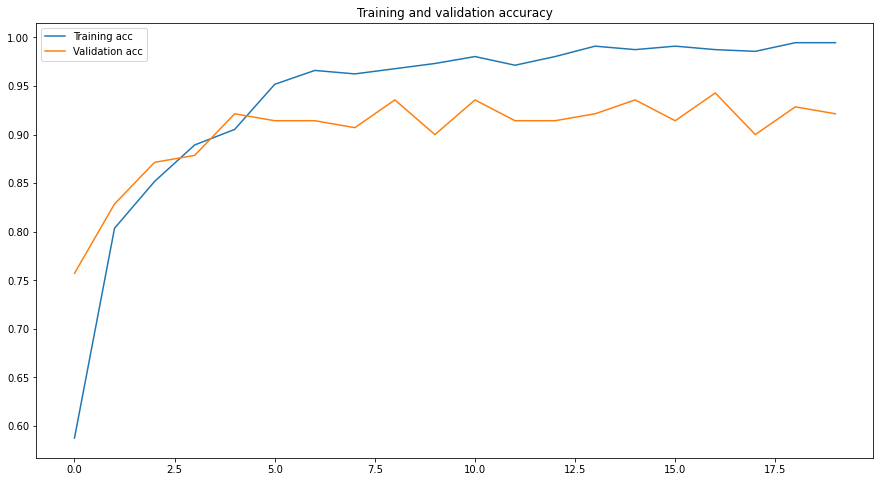

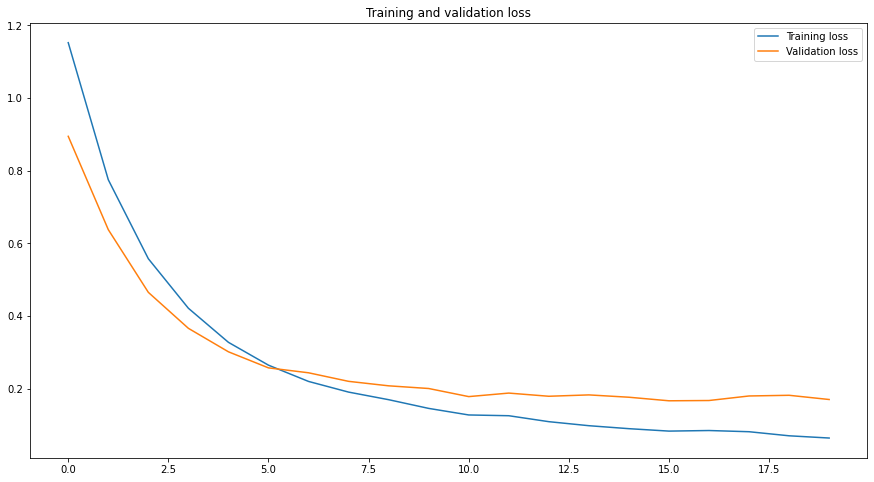

In [16]:
plot_history(history)

In [17]:
score = model.evaluate(X_test_sc, y_test, verbose=0) 
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

Test score: 0.11588935554027557
Test accuracy: 0.9433333277702332


## CNN

In [18]:
class_names = ['mountain', 'street', 'glacier', 'buildings', 'sea', 'forest']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}

nb_classes = len(class_names)

IMAGE_SIZE = (36, 36)

In [19]:
def load_data():
    datasets = ['seg_train/seg_train', 'seg_test/seg_test']
    output = []
    
    for dataset in datasets:
        
        images = []
        labels = []
        
        print("Loading {}".format(dataset))
        
        for folder in os.listdir(dataset):
            label = class_names_label[folder]
            
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):
                
                img_path = os.path.join(os.path.join(dataset, folder), file)
                
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, IMAGE_SIZE) 
                
                images.append(image)
                labels.append(label)
                
        images = np.array(images, dtype = 'float32')
        labels = np.array(labels, dtype = 'int32')   
        
        output.append((images, labels))

    return output

In [20]:
(train_images, train_labels), (test_images, test_labels) = load_data()

  1%|▍                                                                              | 12/2191 [00:00<00:19, 114.50it/s]

Loading seg_train/seg_train


  3%|██▏                                                                             | 12/437 [00:00<00:03, 119.65it/s]

Loading seg_test/seg_test


100%|███████████████████████████████████████████████████████████████████████████████| 501/501 [00:02<00:00, 170.67it/s]


In [21]:
train_images, train_labels = shuffle(train_images, train_labels, random_state=25)

In [22]:
train_images.shape

(14034, 36, 36, 3)

In [23]:
test_images.shape

(3000, 36, 36, 3)

In [24]:
train_images = train_images / 255.0 
test_images = test_images / 255.0

In [25]:
_, train_counts = np.unique(train_labels, return_counts=True)

([<matplotlib.patches.Wedge at 0x2644188a550>,
 [Text(0.9306191182919412, 0.5864708489511904, 'mountain'),
  Text(-0.09566683278348759, 1.0958320387291003, 'street'),
  Text(-1.007803025850412, 0.4408322368960259, 'glacier'),
  Text(-0.8976408457780202, -0.6357994274855244, 'buildings'),
  Text(0.04947780812286995, -1.0988866850150458, 'sea'),
  Text(0.9608894621297182, -0.5354357492436055, 'forest')],
 [Text(0.5076104281592406, 0.3198931903370129, '17.9%'),
  Text(-0.05218190879099322, 0.5977265665795092, '17.0%'),
  Text(-0.549710741372952, 0.2404539473978323, '17.1%'),
  Text(-0.4896222795152837, -0.3467996877193769, '15.6%'),
  Text(0.026987895339747242, -0.599392737280934, '16.2%'),
  Text(0.5241215247980281, -0.29205586322378474, '16.2%')])

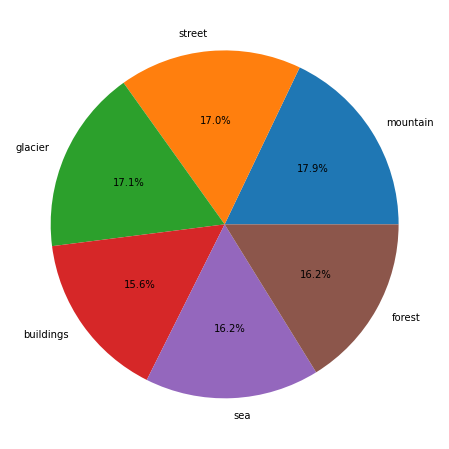

In [26]:
plt.pie(train_counts, labels=class_names, autopct='%1.1f%%')

In [34]:
def display_examples(class_names, images, labels):
    fig = plt.figure(figsize=(10,10))
    fig.suptitle("Examples of images", fontsize=16)
    k = 0
    for i in range(0, 100, 4):
        plt.subplot(5,5,k+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.binary)
        plt.xlabel(class_names[labels[i]])
        k+=1
    plt.show()

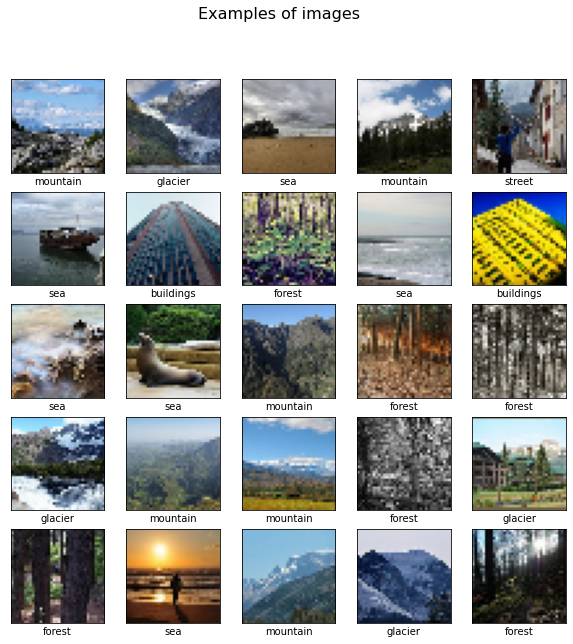

In [35]:
display_examples(class_names, train_images, train_labels)

In [36]:
y_train = keras.utils.to_categorical(train_labels)
y_test = keras.utils.to_categorical(test_labels)

In [37]:
model = keras.Sequential()
model.add(Conv2D(32, 3, padding='valid', activation='relu', input_shape=(36, 36, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())
model.add(Conv2D(64, 3, padding='same', activation='relu'))
model.add(Conv2D(64, 3, padding='same', activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Conv2D(128, 3, padding='same', activation='relu'))
model.add(Conv2D(128, 3, padding='same', activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(6, activation='softmax'))

model.summary()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 34, 34, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 17, 17, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 17, 17, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 17, 17, 64)        18496     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 17, 17, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 64)         

In [38]:
monitor = keras.callbacks.EarlyStopping(patience=5, min_delta=0.01, monitor='val_accuracy', restore_best_weights=True)

In [39]:
history = model.fit(train_images, y_train, epochs=30, batch_size=64, validation_split=0.2, verbose=1, callbacks=[monitor])

Epoch 1/30
176/176 [==============================] - 44s 245ms/step - loss: 1.3571 - accuracy: 0.5221 - val_loss: 2.6678 - val_accuracy: 0.3762
Epoch 2/30
176/176 [==============================] - 41s 235ms/step - loss: 0.8234 - accuracy: 0.6945 - val_loss: 2.3164 - val_accuracy: 0.5198
Epoch 3/30
176/176 [==============================] - 46s 261ms/step - loss: 0.6914 - accuracy: 0.7535 - val_loss: 1.1636 - val_accuracy: 0.6220
Epoch 4/30
176/176 [==============================] - 48s 273ms/step - loss: 0.6132 - accuracy: 0.7783 - val_loss: 0.6221 - val_accuracy: 0.7887
Epoch 5/30
176/176 [==============================] - 44s 250ms/step - loss: 0.5336 - accuracy: 0.8050 - val_loss: 0.6278 - val_accuracy: 0.8001
Epoch 6/30
176/176 [==============================] - 49s 279ms/step - loss: 0.4921 - accuracy: 0.8209 - val_loss: 0.6388 - val_accuracy: 0.7830
Epoch 7/30
176/176 [==============================] - 47s 266ms/step - loss: 0.4467 - accuracy: 0.8360 - val_loss: 0.6082 - val_ac

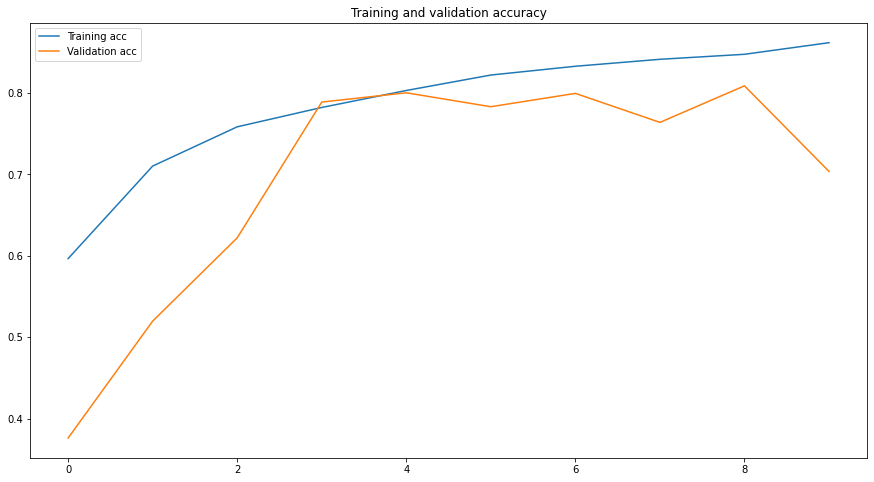

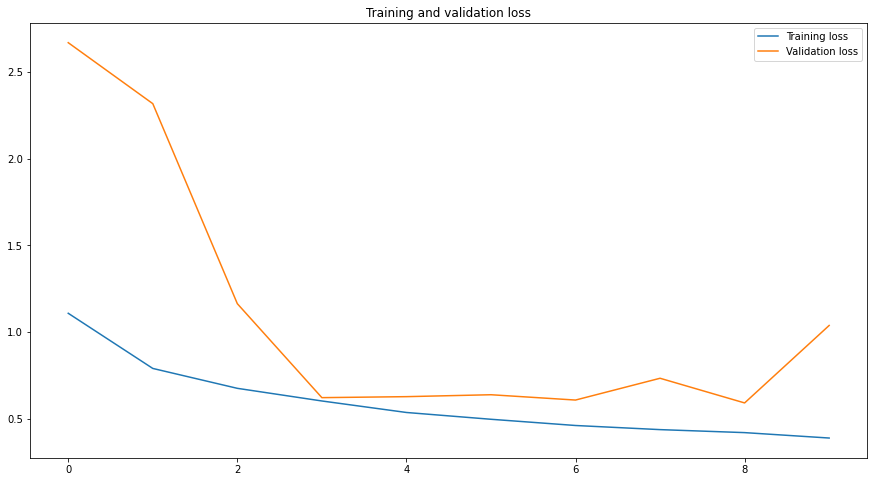

In [40]:
plot_history(history)

In [41]:
score = model.evaluate(test_images, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.6073060035705566
Test accuracy: 0.7976666688919067


In [42]:
predictions = model.predict(test_images)
pred_labels = np.argmax(predictions, axis = 1)

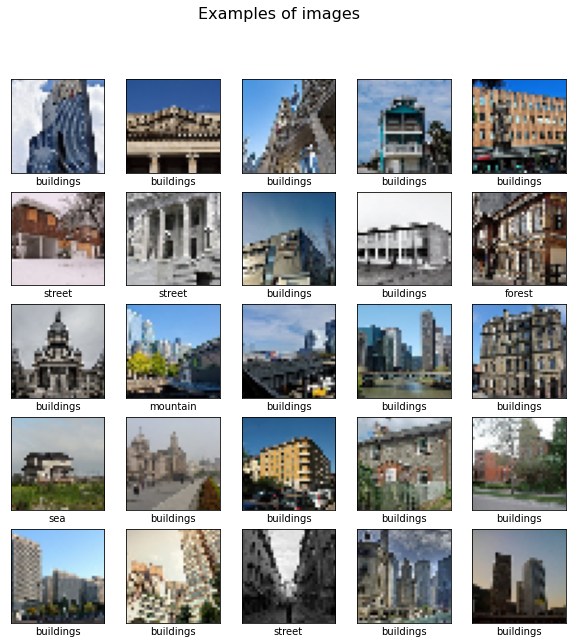

In [43]:
display_examples(class_names, test_images, pred_labels)

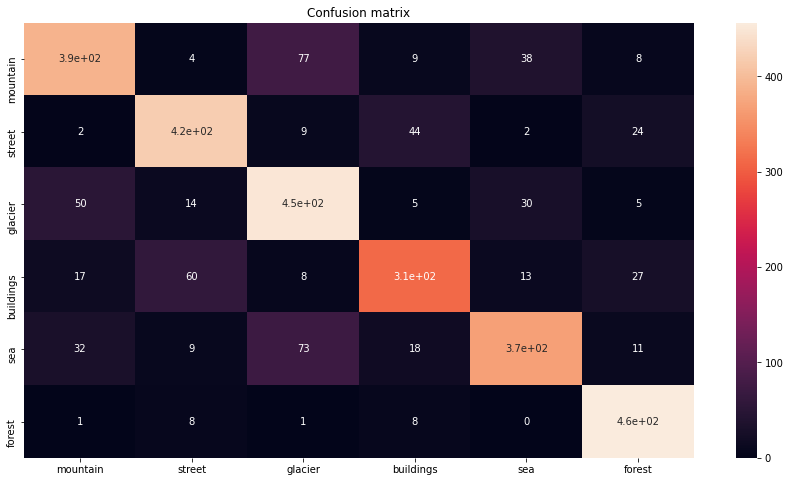

In [44]:
CM = confusion_matrix(test_labels, pred_labels)
ax = plt.axes()
sns.heatmap(CM, annot=True, 
           xticklabels=class_names, 
           yticklabels=class_names, ax=ax)
ax.set_title('Confusion matrix')
plt.show()